In [1]:
# first let's import our packages
from scipy.optimize import minimize # finding optimal params in models
import os                           # operating system tools
import numpy as np                  # matrix/array functions
import pandas as pd                 # loading and manipulating data
import matplotlib.pyplot as plt     # plotting

import reinforcementLearningFns as rlf
import plotFns as psyplt
import helperFns as mf
import datetime

curPath = os.path.abspath(os.getcwd())

%load_ext autoreload
%autoreload 2

np.random.seed(2021)                # set seed for reproducibility

In [10]:
## Code to fit Choice-History model to learning trajectory for mouse JC059.

IDs = ('JC059',)

dataBase =  os.path.abspath(os.path.join(curPath,"data/Trajectories/with_bias_learning/"))

alpha = 0 # "Rate", how much the prediction error updates the weights
beta = 0 # Generalization decay constant: how much does the "update" affect both stimulus associations vs. being stimulus-specific? High = more stimulus-specific
theta = 0 # When large, adds "randomness" to the decision function
bias = 0 # Initial starting bias (towards high), is added to the weight*stimulus before the logistic function.

iQ = [0, 0]

model_params = {
    'N': np.nan,
    'alpha': alpha,
    'beta': 1000,
    'theta': theta,
    'bias': bias,
    'init_Q': iQ,
    'max_num_cts': 3,
}

#initialize dataframe to store results
df = pd.DataFrame(index=range(0,len(IDs)), columns=['id','bias','alpha','beta','init_Q','nLL'])

nParams = 4

ns = 1

bias_grid = np.linspace(-0.15, 0.15, ns)
alpha_grid= np.linspace(.0003,.01,ns)
beta_grid = np.linspace(.001,.5,ns)
init_q_grid = np.linspace(-0.2,0.2,ns)

bias_range = (-0.4, 0.4)
alpha_range = (.00001,.1)
beta_range = (.0001,20)
init_q_range = (-1, 1)

individualFits = {}

dataframefull = ()

for index, ID in enumerate(IDs):

    loaded_dict = mf.loadSavedFits(ID, dataBase, ending = '_trainingDataBias')
    subj_choice = np.array(loaded_dict['y'])
    stim_cat = np.array(loaded_dict['answer']) - 1

    # gradient descent to minimize neg LL
    res_nll = np.inf # set initial neg LL to be inf
    
    df_temp = pd.DataFrame(index=range(0,ns**nParams), columns=['bias','alpha','beta','init_Q','nLL','N','D'])

    ii = 0
    # guess several different starting points for alpha, theta, beta
    for bias_guess in bias_grid:
        for alpha_guess in alpha_grid:
            for beta_guess in beta_grid:
                for init_q_guess in init_q_grid:
                    # guesses for alpha, beta, theta, init will change on each loop
                    init_guess = (bias_guess, alpha_guess, beta_guess, init_q_guess)

                    # minimize neg LL
                    result = minimize(rlf.fitLearning, 
                                        init_guess, 
                                        (model_params, subj_choice, stim_cat), 
                                        bounds = (bias_range, alpha_range, beta_range, init_q_range))
                    
                    # if current negLL is smaller than the last negLL,
                    # then store current data

                    df_temp.at[ii, 'bias'] = result.x[0]
                    df_temp.at[ii, 'alpha'] = result.x[1]
                    df_temp.at[ii, 'beta'] = result.x[2]
                    df_temp.at[ii, 'init_Q'] = result.x[3]
                    df_temp.at[ii, 'nLL'] = result.fun
                    df_temp.at[ii, 'N'] = len(subj_choice)
                    df_temp.at[ii, 'D'] = len(init_guess)
                    ii += 1

                    if result.fun < res_nll and result.success:
                        res_nll = result.fun
                        param_fits = result.x
                    
    df_temp = df_temp.sort_values(by = ['nLL'])
    df_temp = df_temp.reset_index()

    df_temp['index'] = ID
    if len(dataframefull) == 0:
        dataframefull = df_temp
    else:
        dataframefull = pd.concat([dataframefull, df_temp])

    # also, compute BIC
    BIC = len(init_guess) * np.log(len(subj_choice)) + 2*res_nll

    #store in dataframe
    df.at[index, 'id'] = ID
    df.at[index, 'bias'] = param_fits[0]
    df.at[index, 'alpha'] = param_fits[1]
    df.at[index, 'beta'] = param_fits[2]
    df.at[index, 'init_Q'] = param_fits[3]
    df.at[index, 'nLL'] = res_nll
    df.at[index, 'BIC'] = BIC

    today = datetime.datetime.now()
    date_time = today.strftime("%y%m%d")

    tmp = 'new_data/' + date_time + '_RL_Data/'
   
    if not os.path.isdir(tmp):
        os.makedirs(tmp)

    saveName = '{}param_{}.csv'.format(nParams,date_time)

    dataframefull.to_csv(tmp + 'fits_' + saveName)
    df.to_csv(tmp + 'model_' + saveName)

    print(fr'subject {ID}: bias={param_fits[0]:.4f}, alpha={param_fits[1]:.4f}, beta={param_fits[2]:.4f}, init_Q = {param_fits[3]:.4f}; negLL={res_nll:.2f}; BIC={BIC:.2f}')

subject JC059: bias=-0.1229, alpha=0.0013, beta=0.3554, init_Q = -0.4964; negLL=2547.83; BIC=5129.27


Starting Learning Simulation


/Users/jaredcollina/anaconda3/envs/behavior_analysis/lib/python3.11/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/Users/jaredcollina/anaconda3/envs/behavior_analysis/lib/python3.11/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/Users/jaredcollina/anaconda3/envs/behavior_analysis/lib/python3.11/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))


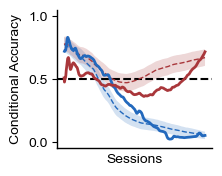

In [15]:
## Code to load Choice-History model fit for mouse JC059, simulate 50 learning trajectories and plot results alongside behavioral data

ID = 'JC059'

mfN = 4
reps = 50

smoothF = 5
nPoints = 400
smooth2 = 5

sim = rlf.simulateFromFit(ID, mfN, reps, folder = 'new_data')

fig, ax = psyplt.plotFitSimulations(sim, reps, nPoints, smoothF, smooth2)
plt.show()